# Vision Transformer from scratch

In [ ]:
import numpy as np
from tqdm.notebook import tqdm as tqdm_notebook
from tqdm import trange
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

from torchvision.transforms import ToTensor 
from torchvision.datasets.mnist import MNIST

In [2]:
np.random.seed(0)
torch.manual_seed(0)

Using device: mps


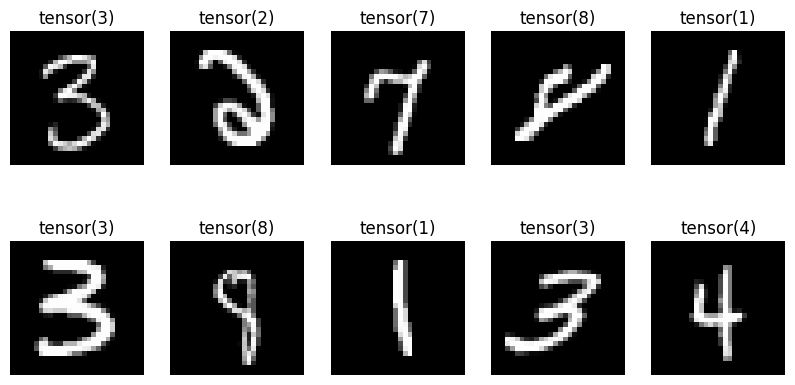

In [41]:
# Load the MNIST dataset
transform = ToTensor()
mnist_train = MNIST(root="./data", train=True, download=True, transform=transform)
mnist_test = MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=64, shuffle=False)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

plt.figure(figsize=(10, 5))
for i, batch in enumerate(train_loader):
    plt.subplot(2, 5, i + 1)
    x, y = batch
    plt.imshow(x[0, 0], cmap="gray")
    plt.title(y[0])
    plt.axis("off")
    if i == 9:
        break

## Patchfitying the input image

In [42]:
def patchify(images, n_patches):
    n, c, h, w = images.shape

    assert h == w, "Patchifying is currently only supported for square images"

    patches = torch.zeros((n, n_patches**2, h * w * c // n_patches**2), device=device)
    patch_size = h // n_patches

    for idx, image in enumerate(images):
        for i in range(n_patches):
            for j in range(n_patches):
                patch = image[
                    :,
                    i * patch_size : (i + 1) * patch_size,
                    j * patch_size : (j + 1) * patch_size,
                ]
                patches[idx, i * n_patches + j] = patch.flatten()
    return patches

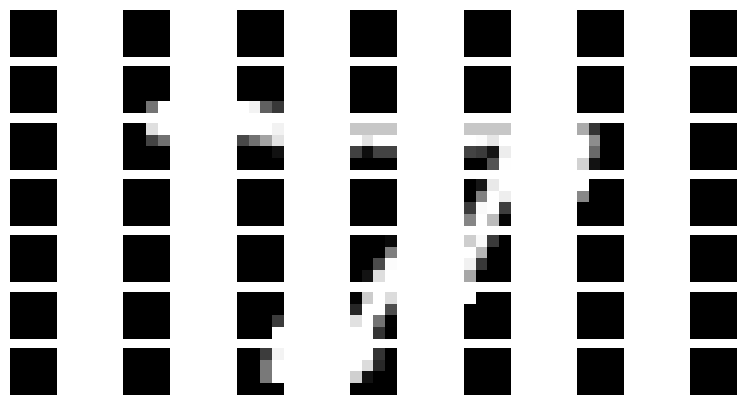

In [44]:
# Testing patchify on a single test image
test_image = next(iter(test_loader))[0][0].to(device)
test_patches = patchify(test_image[None, ...], 7)
plt.figure(figsize=(10, 5))
for i in range(49):
    plt.subplot(7, 7, i + 1)
    plt.imshow(test_patches[0, i].cpu().reshape(4, 4), cmap="gray")
    plt.axis("off")


In [45]:
test_patches.shape

torch.Size([1, 49, 16])

## Positional Encoding

In [46]:
def get_positional_embeddings(sequence_lenght, d):
    embeddings = torch.ones((sequence_lenght, d), device=device)
    for i in range(sequence_lenght):
        for j in range(d):
            if j % 2 == 0:
                embeddings[i, j] = torch.sin(torch.tensor(i / 10000 ** (j / d)))
            else:
                embeddings[i, j] = torch.cos(torch.tensor(i / 10000 ** ((j - 1) / d)))
    return embeddings

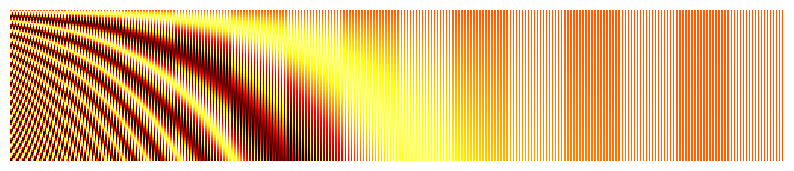

In [48]:
plt.figure(figsize=(10, 5))
plt.imshow(get_positional_embeddings(100, 512).cpu(), cmap="hot", interpolation="nearest")
plt.axis("off")
plt.show()

## Encoder Layer

### Layer Normalization

In [50]:
# Testing Layer Norm
ln = nn.LayerNorm(8).to(device)

ln(torch.rand(50, 8).to(device)).shape

torch.Size([50, 8])

In [51]:
# Test layer norm on a sample matrix
sample_ = torch.rand((1, 10, 8))
sample_

tensor([[[0.4155, 0.3572, 0.3318, 0.2952, 0.6500, 0.5281, 0.2995, 0.2435],
         [0.2587, 0.4390, 0.3708, 0.7622, 0.0628, 0.2136, 0.3954, 0.5200],
         [0.4476, 0.9975, 0.0736, 0.5079, 0.0022, 0.4796, 0.4582, 0.0785],
         [0.8059, 0.2213, 0.2340, 0.2637, 0.1158, 0.3127, 0.1174, 0.5191],
         [0.8211, 0.6919, 0.4483, 0.5797, 0.7905, 0.8342, 0.9700, 0.1365],
         [0.1580, 0.9303, 0.4530, 0.8254, 0.0560, 0.7837, 0.1469, 0.8827],
         [0.3705, 0.6009, 0.7594, 0.6041, 0.1816, 0.2716, 0.9085, 0.4576],
         [0.3986, 0.8260, 0.0152, 0.3265, 0.9573, 0.4310, 0.8078, 0.6056],
         [0.5874, 0.2185, 0.9951, 0.4978, 0.0738, 0.3349, 0.0968, 0.4365],
         [0.8234, 0.2480, 0.5729, 0.1863, 0.7848, 0.5895, 0.9069, 0.9778]]])

In [52]:
# mean of the sample
mean_ = sample_.mean(axis=-1, keepdims=True)
std_ = sample_.std(axis=-1, keepdims=True)
mean_, std_

(tensor([[[0.3901],
          [0.3778],
          [0.3806],
          [0.3237],
          [0.6590],
          [0.5295],
          [0.5193],
          [0.5460],
          [0.4051],
          [0.6362]]]),
 tensor([[[0.1365],
          [0.2113],
          [0.3264],
          [0.2326],
          [0.2661],
          [0.3688],
          [0.2462],
          [0.3127],
          [0.3013],
          [0.2943]]]))

In [53]:
layer_normed_sample_ = ln(sample_.to(device))
layer_normed_sample_

tensor([[[ 0.1988, -0.2575, -0.4563, -0.7427,  2.0351,  1.0801, -0.7093,
          -1.1482],
         [-0.6024,  0.3093, -0.0354,  1.9447, -1.5939, -0.8307,  0.0888,
           0.7195],
         [ 0.2192,  2.0202, -1.0057,  0.4169, -1.2393,  0.3240,  0.2542,
          -0.9896],
         [ 2.2158, -0.4708, -0.4122, -0.2761, -0.9556, -0.0508, -0.9481,
           0.8977],
         [ 0.6509,  0.1320, -0.8464, -0.3185,  0.5280,  0.7039,  1.2491,
          -2.0989],
         [-1.0768,  1.1618, -0.2218,  0.8577, -1.3725,  0.7369, -1.1091,
           1.0239],
         [-0.6459,  0.3545,  1.0424,  0.3681, -1.4660, -1.0753,  1.6901,
          -0.2678],
         [-0.5039,  0.9573, -1.8145, -0.7502,  1.4060, -0.3931,  0.8948,
           0.2037],
         [ 0.6468, -0.6621,  2.0933,  0.3288, -1.1754, -0.2490, -1.0937,
           0.1114],
         [ 0.6800, -1.4098, -0.2299, -1.6341,  0.5398, -0.1696,  0.9830,
           1.2407]]], device='mps:0', grad_fn=<NativeLayerNormBackward0>)

In [54]:
mean_ = layer_normed_sample_.mean(axis=-1, keepdims=True)
std_ = layer_normed_sample_.std(axis=-1, keepdims=True)
mean_, std_

(tensor([[[ 1.4901e-08],
          [-2.9802e-08],
          [ 2.9802e-08],
          [-2.2352e-08],
          [ 7.4506e-08],
          [-8.9407e-08],
          [ 0.0000e+00],
          [ 8.9407e-08],
          [-7.4506e-09],
          [-8.9407e-08]]], device='mps:0', grad_fn=<MeanBackward1>),
 tensor([[[1.0687],
          [1.0689],
          [1.0690],
          [1.0689],
          [1.0690],
          [1.0690],
          [1.0689],
          [1.0690],
          [1.0690],
          [1.0690]]], device='mps:0', grad_fn=<StdBackward0>))

### Multi-headed self-attention

In [58]:
class MyMHSA(nn.Module):
    def __init__(self, d, n_heads=2):
        super(MyMHSA, self).__init__()
        self.n_heads = n_heads
        self.d = d

        assert d % n_heads == 0, "d must be divisible by n_heads"

        d_head = d // n_heads
        self.q_mappings = nn.ModuleList(
            [nn.Linear(d_head, d_head, device=device) for _ in range(n_heads)]
        )
        self.k_mappings = nn.ModuleList(
            [nn.Linear(d_head, d_head, device=device) for _ in range(n_heads)]
        )
        self.v_mappings = nn.ModuleList(
            [nn.Linear(d_head, d_head, device=device) for _ in range(n_heads)]
        )
        self.d_head = d_head
        self.softmax = nn.Softmax(dim=-1).to(device)

    def forward(self, sequences):
        """
        sequences' shape:       (N, seq_len, token_dim)
        We go into shape:       (N, seq_len, n_heads, token_dim // n_heads)
        And get back to :       (N, seq_len, item_dim) [via concatenation and linear transformation]
        """

        result = []

        for sequence in sequences:
            seq_result = []
            for head in range(self.n_heads):
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]

                seq = sequence[:, head * self.d_head : (head + 1) * self.d_head]
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

                attention = self.softmax(q @ k.T / self.d_head**0.5)
                seq_result.append(attention @ v)
            result.append(torch.hstack(seq_result))
        return torch.cat([torch.unsqueeze(r, dim=0) for r in result]).to(device)

### The Encoder layer, itself!

In [59]:
class MyEncoder(nn.Module):
    def __init__(self, hidden_dim, n_heads, mlp_ratio=4):
        super(MyEncoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_heads = n_heads

        self.norm_1 = nn.LayerNorm(hidden_dim).to(device)
        self.mhsa = MyMHSA(hidden_dim, n_heads).to(device)

        self.norm_2 = nn.LayerNorm(hidden_dim).to(device)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * mlp_ratio),
            nn.ReLU(),
            nn.Linear(hidden_dim * mlp_ratio, hidden_dim),
        ).to(device)

    def forward(self, x):
        out = x + self.mhsa(self.norm_1(x))
        return out + self.mlp(self.norm_2(out))

In [60]:
# Testing a sample input to the Encoder Block
encoder = MyEncoder(hidden_dim=8, n_heads=2).to(device)
sample_input = torch.rand((7, 50, 8)).to(device)
encoder(sample_input).shape

torch.Size([7, 50, 8])

In [63]:
class MyViT(nn.Module):
    def __init__(
        self,
        chw=(1, 28, 28),
        n_patches=7,
        n_blocks=2,
        hidden_dim=8,
        n_heads=2,
        out_dims=10,
    ):
        super(MyViT, self).__init__()

        self.chw = chw
        self.n_patches = n_patches

        assert chw[1] % n_patches == 0, "Image height must be divisible by n_patches"
        assert chw[2] % n_patches == 0, "Image width must be divisible by n_patches"

        self.patch_size = (chw[1] // n_patches, chw[2] // n_patches)

        # 1. Linear mapping
        self.hidden_dim = hidden_dim
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_dim, device=device)

        # 2. Add learnable classification token
        self.cls_token = nn.Parameter(torch.rand(1, self.hidden_dim).to(device))

        # 3. Positional embeddings
        self.pos_embed = nn.Parameter(
            get_positional_embeddings(self.n_patches**2 + 1, self.hidden_dim).to(device)
        )
        self.pos_embed.requires_grad = False

        # 4. Transformer Encoder Block
        self.blocks = nn.ModuleList(
            [MyEncoder(self.hidden_dim, n_heads).to(device) for _ in range(n_blocks)]
        )

        # 5. Classification MLP
        self.mlp = nn.Sequential(
            nn.Linear(self.hidden_dim, out_dims),
            nn.Softmax(dim=-1),
        ).to(device)

    def forward(self, images):
        n, h, w, c = images.shape
        patches = patchify(images, self.n_patches)
        tokens = self.linear_mapper(patches)
        tokens = torch.cat((self.cls_token.expand(n, 1, -1), tokens), dim=1)
        pos_embed = self.pos_embed.repeat(n, 1, 1)
        out = tokens + pos_embed

        for block in self.blocks:
            out = block(out)
        out = out[:, 0]
        return self.mlp(out)

In [65]:
# Testing ViT Model
sample_input = torch.rand((7, 1, 28, 28), device=device)
sample_model = MyViT().to(device)
sample_model(sample_input).shape

torch.Size([7, 10])

## Training Loop

In [68]:
device = "mps"
N_EPOCHS = 5
LR = 0.001

model = MyViT(
    chw=(1, 28, 28), n_patches=7, n_blocks=2, hidden_dim=8, n_heads=4, out_dims=10
).to(device)

optimizer = Adam(model.parameters(), lr=LR)
criterion = CrossEntropyLoss()

for epoch in trange(N_EPOCHS, desc="Training"):
    train_loss = 0.0
    pbar = tqdm_notebook(train_loader, desc="Epoch {} in training".format(epoch + 1))
    for batch in pbar:
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = model(x)
        loss = criterion(y_hat, y)

        train_loss += loss.detach().cpu().item() / len(train_loader)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.set_postfix(loss=train_loss)

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1 in training:   0%|          | 0/938 [00:00<?, ?it/s]

Training:  20%|██        | 1/5 [09:58<39:53, 598.31s/it]

Epoch 2 in training:   0%|          | 0/938 [00:00<?, ?it/s]

Training:  40%|████      | 2/5 [19:52<29:48, 596.05s/it]

Epoch 3 in training:   0%|          | 0/938 [00:00<?, ?it/s]

Training:  60%|██████    | 3/5 [29:50<19:53, 596.82s/it]

Epoch 4 in training:   0%|          | 0/938 [00:00<?, ?it/s]

Training:  80%|████████  | 4/5 [39:43<09:55, 595.30s/it]

Epoch 5 in training:   0%|          | 0/938 [00:00<?, ?it/s]

Training: 100%|██████████| 5/5 [49:36<00:00, 595.33s/it]


## Testing

In [69]:
with torch.no_grad():
    correct, total = 0, 0
    test_loss = 0.0
    for batch in tqdm_notebook(test_loader, desc="Testing"):
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = model(x)
        loss = criterion(y_hat, y)
        test_loss += loss.detach().cpu().item() / len(test_loader)

        correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
        total += len(x)
    print(f"Test loss: {test_loss:.2f}")
    print(f"Test accuracy: {correct / total * 100:.2f}%")

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Test loss: 1.82
Test accuracy: 63.91%


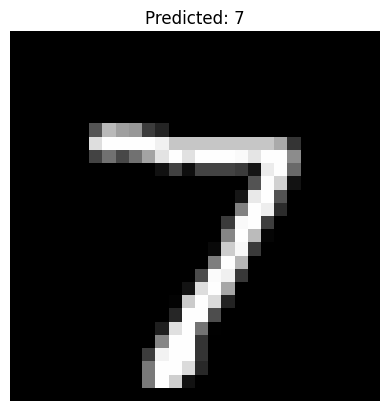

In [70]:
# randomly choose a test image, give it to model, plot the image and show the predicted label
data_iter = iter(test_loader)
image, label = next(data_iter)
image, label = image.to(device), label.to(device)

model.eval()
predicted_label = torch.argmax(model(image), dim=1)

plt.imshow(image[0, 0].cpu(), cmap="gray")
plt.title(f"Predicted: {predicted_label[0]}")
plt.axis("off")
plt.show()